In [252]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

In [253]:
lang = "ru"

In [254]:
df_comb = pd.read_excel("../files/input/combined_data.xlsx")

In [255]:
df_comb.head()

,person,content
0,George Clooney,"George Timothy Clooney (born May 6, 1961) is a..."
1,Shah Rukh Khan,Shah Rukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn]; bo...
2,Leonardo DiCaprio,Leonardo Wilhelm DiCaprio (; Italian: [diˈkaːp...
3,Will Smith,"Willard Carroll Smith II (born September 25, ..."
4,Kamal Haasan,Kamal Haasan (born 7 November 1954) is an Indi...


In [256]:
## lang detect python

In [257]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

df_comb["actual_lang"] = df_comb["content"].apply(detect)

In [258]:
## add this comment to code

a = df_comb[df_comb["actual_lang"]=="en"]
a[a.duplicated('person')]

,person,content,actual_lang
55,Kamal Haasan,"Kamal Haasan (Ramanathapuram, 7 novembre 1954)...",en
78,James Patterson,"James Patterson (Newburgh, 22 marzo 1947) è un...",en


In [259]:
df_comb.actual_lang.value_counts()

en    53
ru    51
it    49
Name: actual_lang, dtype: int64

In [260]:
## filter to required lang

In [261]:
df = df_comb[df_comb["actual_lang"] == str(lang)].reset_index(drop=True)

In [262]:
df.head()

,person,content,actual_lang
0,"Клуни, Джордж",Джордж Ти́моти Клу́ни (англ. George Timothy Cl...,ru
1,"Хан, Шахрух","Ша́хрух Хан (хинди शाहरुख़ ख़ान, урду شاہ رخ خ...",ru
2,"Ди Каприо, Леонардо",Леона́рдо Вильге́льм Ди Ка́прио (англ. Leonard...,ru
3,"Смит, Уилл",Уи́ллард Кэ́рролл (Уи́лл) Смит Второй (англ. W...,ru
4,Камал Хасан,"Камал Хасан (англ. Kamal Haasan, там. கமல்ஹாசன...",ru


In [263]:
import warnings
warnings.filterwarnings('ignore')
lang_models = {"en": spacy.load("en_core_web_md"), "it": spacy.load("it_core_news_md"), "ru": spacy.load("ru_core_news_md")}

In [264]:
# Our spaCy model:
nlp = lang_models[str(lang)]
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []
for summary in nlp.pipe(df['content']):
    proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    tokens.append(proj_tok)

In [265]:
df['tokens'] = tokens
df['tokens'][:3]

0    [джордж, англ, george, timothy, clooney, род, ...
1    [хан, хинди, урд, شاہ, رخ, англ, shah, rukh, k...
2    [ди, англ, leonardo, wilhelm, dicaprio, род, н...
Name: tokens, dtype: object

In [266]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(df['tokens'])

In [267]:
print(dictionary.token2id)

{'american': 0, 'baby': 1, 'bafta': 2, 'blessed': 3, 'casamigos': 4, 'classics': 5, 'clooney': 6, 'eight': 7, 'entertainment': 8, 'facts': 9, 'forbes': 10, 'george': 11, 'iii': 12, 'life': 13, 'michael': 14, 'mirador': 15, 'mirror': 16, 'movie': 17, 'nbc': 18, 'not': 19, 'of': 20, 'on': 21, 'our': 22, 'project': 23, 'roseanne': 24, 'sacrament': 25, 'section': 26, 'sisters': 27, 'st': 28, 'susanna': 29, 'talk': 30, 'tba': 31, 'tequila': 32, 'the': 33, 'time': 34, 'timothy': 35, 'watch': 36, 'август': 37, 'авраам': 38, 'аврора': 39, 'автобиография': 40, 'агент': 41, 'адаптация': 42, 'адаптированный': 43, 'аделиа': 44, 'академия': 45, 'активизм': 46, 'активист': 47, 'активный': 48, 'актриса': 49, 'актёр': 50, 'актёра': 51, 'актёру': 52, 'актёры': 53, 'акция': 54, 'аламуддин': 55, 'александр': 56, 'аллен': 57, 'амаль': 58, 'американский': 59, 'англ': 60, 'англия': 61, 'анджелес': 62, 'апрель': 63, 'арго': 64, 'арест': 65, 'арестовать': 66, 'армянин': 67, 'аугуста': 68, 'аффлеком': 69, 'бае

In [268]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [269]:
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

In [270]:
# set baseline model
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

Running iteration number 1
Running iteration number 2
Running iteration number 3
Running iteration number 4
Running iteration number 5
Running iteration number 6
Running iteration number 7
Running iteration number 8
Running iteration number 9


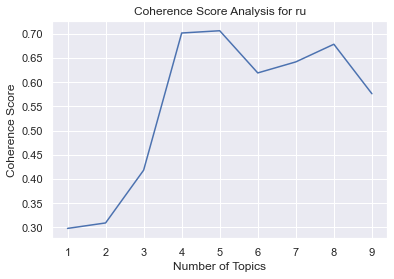

In [271]:
topics = []
score = []
for i in range(1,10,1):
    print("Running iteration number " + str(i))
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, texts = df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score Analysis for ' + str(lang))
fig.patch.set_facecolor('white')
plt.show()
fig.savefig("../files/output/" + str(lang) + "/coherence_score_" + str(lang) + ".png", bbox_inches='tight')

In [272]:
num_topics = topics[score.index(max(score))]
num_topics

5

In [273]:
print("Number of topics with highest coherence score for " + str(lang) + " model is: " + str(num_topics))

Number of topics with highest coherence score for ru model is: 5


In [274]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=num_topics, workers = 4, passes=100)

In [275]:
lda_model.print_topics(-1)

[(0,
  '0.020*"президент" + 0.018*"трамп" + 0.014*"билл" + 0.010*"выбор" + 0.010*"россия" + 0.009*"пост" + 0.009*"млрд" + 0.008*"состояние" + 0.008*"дональд" + 0.008*"партия"'),
 (1,
  '0.071*"альбом" + 0.038*"песня" + 0.032*"сингл" + 0.025*"выпустить" + 0.016*"billboard" + 0.014*"музыкальный" + 0.013*"чарт" + 0.010*"записать" + 0.010*"you" + 0.009*"музыка"'),
 (2,
  '0.069*"турнир" + 0.036*"финал" + 0.036*"чемпионат" + 0.032*"открытый" + 0.032*"выиграть" + 0.028*"матч" + 0.022*"сезон" + 0.020*"победить" + 0.020*"рейтинг" + 0.020*"проиграть"'),
 (3,
  '0.025*"роман" + 0.016*"кинг" + 0.012*"мужской" + 0.011*"актёр" + 0.010*"написать" + 0.010*"золотой" + 0.008*"писать" + 0.008*"серия" + 0.008*"сняться" + 0.008*"of"'),
 (4,
  '0.053*"матч" + 0.035*"сезон" + 0.032*"чемпион" + 0.027*"выиграть" + 0.025*"команда" + 0.023*"лига" + 0.022*"чемпионат" + 0.020*"рекорд" + 0.017*"клуб" + 0.015*"счёт"')]

In [276]:
# set sort_topics to be False to ensure same order as gensim model
# thing to take note of is that gensim starts from 0, pyldavis starts from 1
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(lda_display, "../files/output/" + str(lang) + "/lda_" + str(lang) + ".html")

In [277]:
df.head()

,person,content,actual_lang,tokens
0,"Клуни, Джордж",Джордж Ти́моти Клу́ни (англ. George Timothy Cl...,ru,"[джордж, англ, george, timothy, clooney, род, ..."
1,"Хан, Шахрух","Ша́хрух Хан (хинди शाहरुख़ ख़ान, урду شاہ رخ خ...",ru,"[хан, хинди, урд, شاہ, رخ, англ, shah, rukh, k..."
2,"Ди Каприо, Леонардо",Леона́рдо Вильге́льм Ди Ка́прио (англ. Leonard...,ru,"[ди, англ, leonardo, wilhelm, dicaprio, род, н..."
3,"Смит, Уилл",Уи́ллард Кэ́рролл (Уи́лл) Смит Второй (англ. W...,ru,"[смит, второй, англ, willard, carroll, will, s..."
4,Камал Хасан,"Камал Хасан (англ. Kamal Haasan, там. கமல்ஹாசன...",ru,"[камал, хасан, англ, kamal, haasan, хинди, род..."


In [278]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=df['tokens']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, df], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['tokens'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index(drop=True)
df_dominant_topic.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']
df_dominant_topic = pd.concat([df,df_dominant_topic], axis=1)
df_dominant_topic

,person,content,actual_lang,tokens,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,"Клуни, Джордж",Джордж Ти́моти Клу́ни (англ. George Timothy Cl...,ru,"[джордж, англ, george, timothy, clooney, род, ...",3,0.8857,"роман, кинг, мужской, актёр, написать, золотой..."
1,"Хан, Шахрух","Ша́хрух Хан (хинди शाहरुख़ ख़ान, урду شاہ رخ خ...",ru,"[хан, хинди, урд, شاہ, رخ, англ, shah, rukh, k...",3,0.9420,"роман, кинг, мужской, актёр, написать, золотой..."
2,"Ди Каприо, Леонардо",Леона́рдо Вильге́льм Ди Ка́прио (англ. Leonard...,ru,"[ди, англ, leonardo, wilhelm, dicaprio, род, н...",3,0.9991,"роман, кинг, мужской, актёр, написать, золотой..."
3,"Смит, Уилл",Уи́ллард Кэ́рролл (Уи́лл) Смит Второй (англ. W...,ru,"[смит, второй, англ, willard, carroll, will, s...",3,0.8255,"роман, кинг, мужской, актёр, написать, золотой..."
4,Камал Хасан,"Камал Хасан (англ. Kamal Haasan, там. கமல்ஹாசன...",ru,"[камал, хасан, англ, kamal, haasan, хинди, род...",3,0.9882,"роман, кинг, мужской, актёр, написать, золотой..."
5,"Круз, Том","Том Круз (англ. Tom Cruise, полное имя Томас К...",ru,"[круз, англ, tom, cruise, полный, имя, томас, ...",3,0.9983,"роман, кинг, мужской, актёр, написать, золотой..."
6,"Джонсон, Дуэйн",Дуэ́йн Ду́глас Джо́нсон (англ. Dwayne Douglas ...,ru,"[англ, dwayne, douglas, johnson, род, май, год...",4,0.6891,"матч, сезон, чемпион, выиграть, команда, лига,..."
7,"Питт, Брэд",Уи́льям Брэ́дли Питт (англ. William Bradley Pi...,ru,"[питт, англ, william, bradley, pitt, род, дека...",3,0.9984,"роман, кинг, мужской, актёр, написать, золотой..."
8,"Депп, Джонни",Джон Кри́стофер (Джо́нни) Депп II (англ. John ...,ru,"[джон, депп, ii, англ, john, christopher, john...",3,0.9293,"роман, кинг, мужской, актёр, написать, золотой..."
9,"Фримен, Морган",Мо́рган Фри́мен (англ. Morgan Freeman; род. 1 ...,ru,"[англ, morgan, freeman, род, июнь, мемфис, тен...",3,0.9153,"роман, кинг, мужской, актёр, написать, золотой..."


In [279]:
writer = pd.ExcelWriter('../files/output/' +str(lang) + '/topic_modelling_output_' + str(lang) + '.xlsx' , engine='xlsxwriter')
workbook = writer.book
workbook.formats[0].set_font_size(12)
df_dominant_topic.to_excel(writer, sheet_name = 'Output', index=False)

for idx, col in enumerate(df_dominant_topic):  # loop through all columns
    series = df_dominant_topic[col]
    max_len = 20
    writer.sheets['Output'].set_column(idx, idx, max_len)  # set column width
    
writer.close()

/Users/bhaveshchainani/virtualenv/proofpoint_code/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/bhaveshchainani/virtualenv/proofpoint_code/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/bhaveshchainani/virtualenv/proofpoint_code/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/bhaveshchainani/virtualenv/proofpoint_code/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from im